In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import sys

sys.path.insert(0, ".")
from src import make_data
datadir = Path("../../data/processed").resolve()

# Linear data
Let's create some linear data

2022-09-23 13:07:42.899 | INFO     | src.make_data:make_linear:27 - Data already generated in /Users/raoulgrouls/code/DME22/data/processed/linear.csv


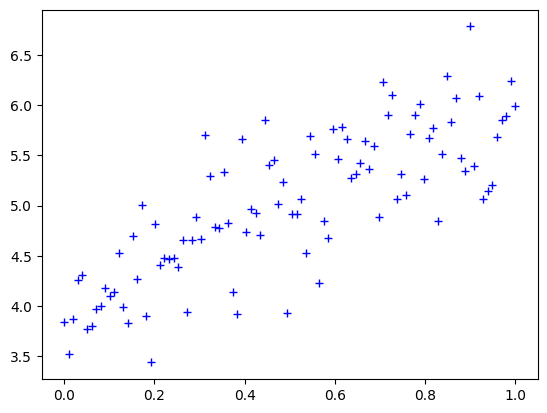

In [41]:
filename = datadir / "linear.csv"
make_data.make_linear(filename, a=2, b=4)
df = pd.read_csv(filename)
plt.plot(df["x"], df["y"], "b+")

The formula for a line is:

$$f(x)= a * x + b$$

We have set the slope $a=2$ and the intercept $b=4$.

It's obvisous that there is a lot of noise, but let's try to fit a linear model.

We will use pymc for the sampling.

In [19]:
import pymc as pm


Now, we will assume that both $a$ and $b$ follow a normal distribution.

In [43]:
df = pd.read_csv(filename)
x = df["x"]
y = df["y"]

model = pm.Model()
with model:
    a = pm.Normal("a")
    b = pm.Normal("b")




We will assume that our model is not perfect. There will be noise.:

$$f(x) = a * x + b + noise$$

But we can assume the noise itself will also follow a normal distribution, with a mean $\mu$ and a standard deviation $\sigma$:
$$ noise \sim \mathscr{N}(\mu, \sigma)$$

This means there are 4 parameters we want to figure out:
 - slope $a$
 - intercept $b$
 - mean $\mu$ from the noise
 - standard deviation $\sigma$ from the noise

 The mean we already know the $\mu$, because we expect:
 $$f(x) - (a*x + b) = \mathscr{N}(0, \sigma)$$

 which is the same as:

 $$f(x) = \mathscr{N}(a*x+b, \sigma)$$

 Because a standard deviation can't be negative, we will need a distribution that is strictly positive.

 We could use a uniform distribution for this. There are better options, but let's start with this.

 the `with` syntax allows us to add new things to our model.


In [44]:
with model:
    sigma = pm.Uniform("sigma", lower=0, upper=10)

    predict = a * x + b

    estimate = pm.Normal("y", mu=predict, sigma=sigma, observed=y)
    

This is all we need to express. With this, we can run simulations to figure out the best fit.

In [45]:
with model:
    result = pm.sample(3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 10 seconds.


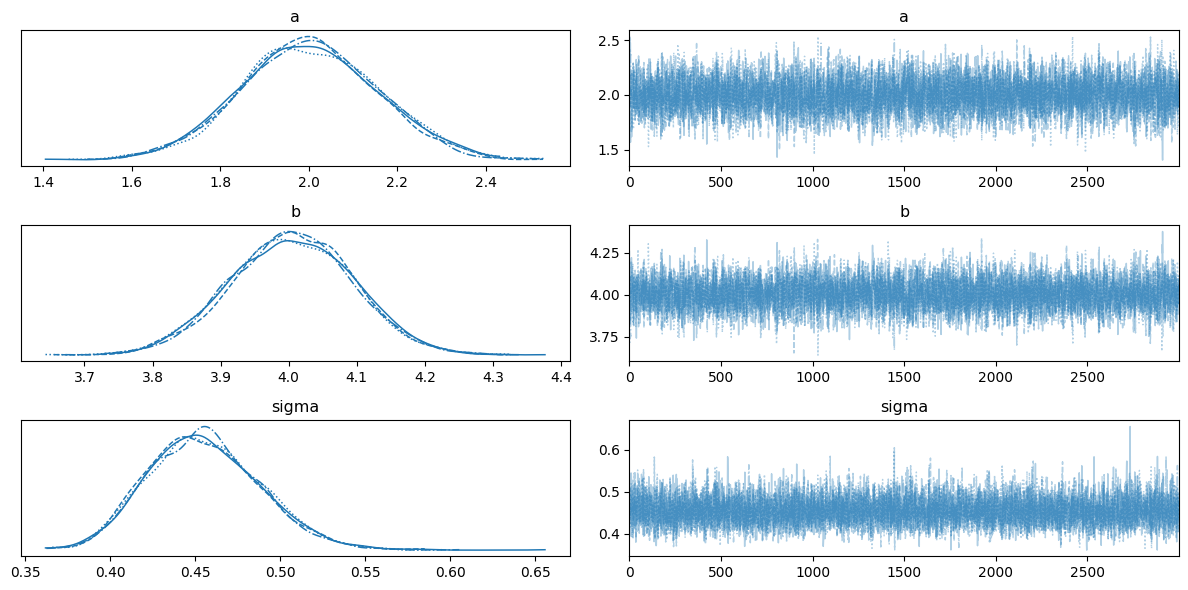

In [48]:
import arviz as az
az.plot_trace(result)
plt.tight_layout()

That's a really nice answer!

Because we generated the data for ourselves, we actually know that the true answers are $a=2.0$ and $b=4.0$. If you look in the sourcecode, you can see that we have set the $\sigma=0.5$.

All the answers are pretty close! And we also have a good grip on how certain we are, given the limited amount of data. 

Using more data would decrease our uncertainty.

# Sinewave

It's straight forward to expand our model to more complex formulas.

Let's make a sine wave with Amplitude 3, frequence 2, and some noise.

In [70]:
filename = datadir / "sine.csv"
make_data.make_sine_wave(filename, a=3, f=2)


2022-09-23 13:54:10.781 | INFO     | src.make_data:make_sine_wave:15 - Data already generated in /Users/raoulgrouls/code/DME22/data/processed/sine.csv


PosixPath('/Users/raoulgrouls/code/DME22/data/processed/sine.csv')

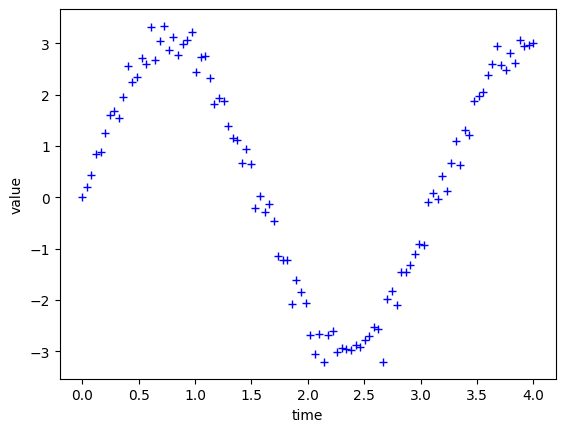

In [71]:

df = pd.read_csv(filename)

plt.plot(df['time'], df['value'], 'b+')
plt.xlabel('time')
plt.ylabel('value');

As you can see, there is some noise, but not too much.
Using the Uniform distribution for the standard deviation works fine, as you have seen in the previous example.

However, saying we know absolutely nothing about the standard deviation is a bit too strong.

We could speed up the calculations by using [what is called a "weakly informative" distribution.](http://www.stat.columbia.edu/~gelman/research/published/taumain.pdf)

It is set up, so that the information it does provide is intentionally weaker than whatever actual knowledge is available.

We can be sure the standard deviaition is below 100. Also, it will be somewhat above 0.

The paper linked suggests using an inverse gamma.
If I make a plot, I hope you understand why that makes sense:

Text(0.5, 1.0, 'Inverse Gamma')

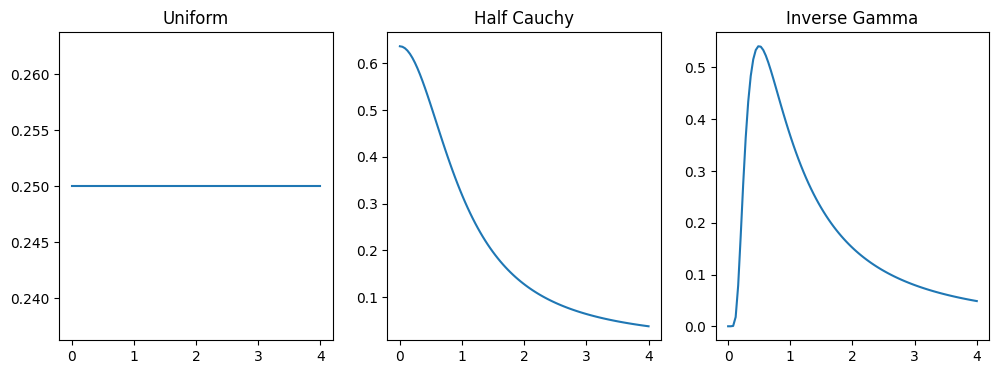

In [76]:
from scipy import stats
fig, ax = plt.subplots(1, 3, figsize=(12,4))

x = df['time']
ax[0].plot(x, stats.uniform.pdf(x, min(x), max(x)))
ax[0].set_title('Uniform')

ax[1].plot(x, stats.halfcauchy.pdf(x))
ax[1].set_title('Half Cauchy')

ax[2].plot(x, stats.invgamma.pdf(x, a=1))
ax[2].set_title('Inverse Gamma')


If you are afraid of picking the wrong distribution, no worries!

As you have seen before, the uniform will work just fine.
The Half Cauchy will also work fine, as will the Inverse Gamma.

However, because it is reasonable to suggest that the standard deviation will neither be 0, nor 100, the inverse gamma will converge faster in most cases. You might want to change the $a$ variable, if you have reasons to do so.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [amp, f, sigma]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 9 seconds.


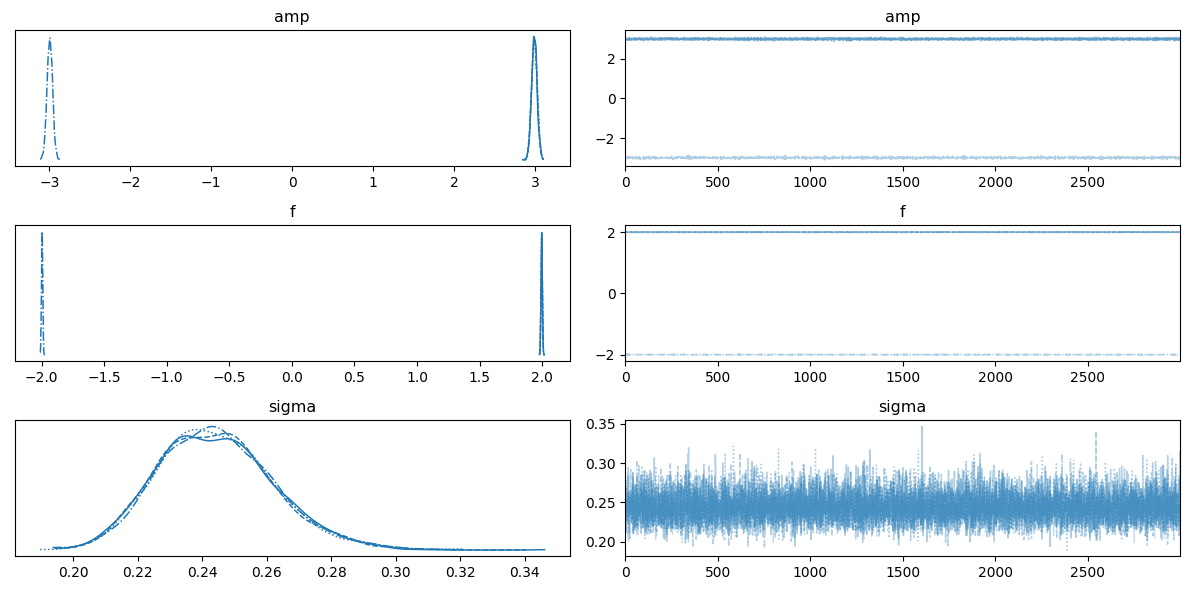

In [77]:
import pymc as pm

df = pd.read_csv(filename)
x = df["time"]
y = df["value"]

model = pm.Model()

with model:
    Amplitude = pm.Normal("amp")
    freq = pm.Normal("f")
    predict = Amplitude * np.sin(freq * x)
    
    sigma = pm.InverseGamma('sigma', alpha=1)
    estimate = pm.Normal("y", mu=predict, sigma=sigma, observed=y)
    
    result = pm.sample(3000)
az.plot_trace(result)
plt.tight_layout()

As you can see, it is possible to flip the amplitude and frequency with a negative sign!

Both give the same result...

You could force the amplitude and frequency to be positive:

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [amp, f, sigma]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 8 seconds.


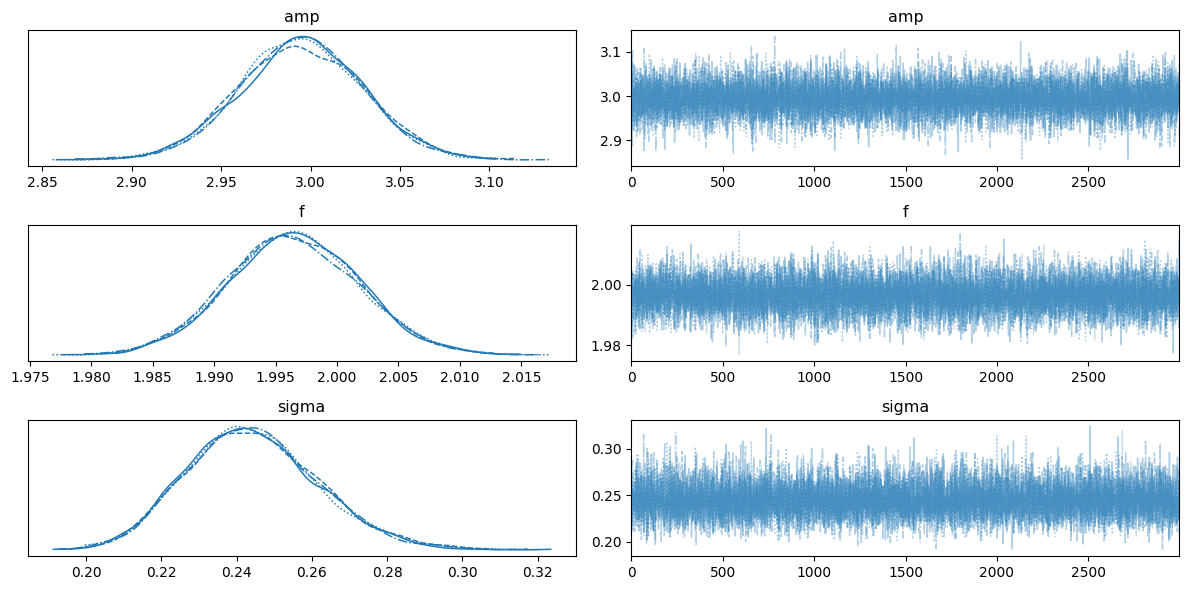

In [78]:
model = pm.Model()

with model:
    Amplitude = pm.HalfNormal("amp")
    freq = pm.HalfNormal("f")
    predict = Amplitude * np.sin(freq * x)
    
    sigma = pm.InverseGamma('sigma', alpha=1)
    estimate = pm.Normal("y", mu=predict, sigma=sigma, observed=y)
    
    result = pm.sample(3000)
az.plot_trace(result)
plt.tight_layout()

We can plot the final result, adding two standard deviations as upper and lower bounds:

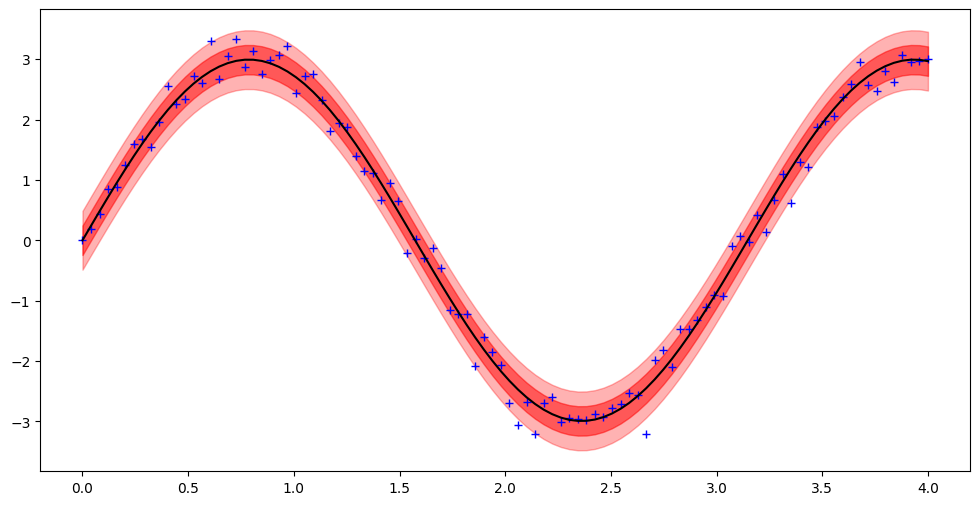

In [79]:
A = result.posterior.amp.median().values
f = result.posterior.f.median().values
sigma = result.posterior.sigma.median().values
yhat = A * np.sin(f*df['time'])

plt.figure(figsize=(12,6))
plt.plot(df['time'], df['value'], 'b+')
plt.plot(df['time'], yhat, color='black', label='model')
plt.fill_between(df['time'], yhat + sigma, yhat-sigma, color='r', alpha=0.5)
plt.fill_between(df['time'], yhat + 2*sigma, yhat-2*sigma, color='r', alpha=0.3);